# Combining climate projections and observations to reduce climate uncertainty: a case study with the KCC R package

This notebook is a companion to the paper 'Reducing climate uncertainty in local temperature projections' by Qasmi and Ribes (2022): https://doi.org/10.21203/rs.3.rs-364943/v3. The Kriging for Climate Change (KCC) package (available at: https://gitlab.com/saidqasmi/KCC) is here used to constrain climate projections from CMIP6 models for the following variables:
- global mean surface temperature (GMST), as done in Ribes et al 2021: https://doi.org/10.1126/sciadv.abc0671
- temperature on a grid point of 2.5 x 2.5 degree centered over Dallas in North America [33.75°N ; 98.75° W].

In [1]:
# Loading KCC package
library(KCC)
# and other useful package(s)
library(abind)

In [2]:
# Set random number generator to ensure reproducibility
set.seed(1)

# Sample size to derive normal distributions
Nres = 1000
sample_str = c("be", paste0("nres",1:Nres))

Some useful plotting functions:

In [3]:
plot_cons = function(X_krig, Xo, ref_plot=NULL, ny=ny, ylim=NULL, color="red") {
    par(font.lab=2,font.axis=2,cex.lab=1.2,mar=c(4,4,1,1),mgp=c(2.5,.7,0))
    x = X_krig[1:ny,,"all","uncons"]
    x_cons = X_krig[1:ny,,"all","cons"]
    obs_x = apply(Xo,1,median)

    # set the ref at the preindustrial level
    ref_plot = 1850:1900
    x = x - ones(x[,1]) %o% apply(x[year %in% ref_plot,], 2, mean)
    x_cons = x_cons - ones(x_cons[,1]) %o% apply(x_cons[year %in% ref_plot,], 2, mean)
    obs_x = obs_x - mean(obs_x[year_obs %in% ref_plot])

    # compute spread
    x_q95 = apply(x[,-1],1,quantile,.95)
    x_q05 = apply(x[,-1],1,quantile,.05)
    xc_q95 = apply(x_cons[,-1],1,quantile,.95)
    xc_q05 = apply(x_cons[,-1],1,quantile,.05)

    plot(year_obs, obs_x, xlim=range(year), ylim=ylim, type="p", pch=16, cex=.8, xlab="Year", ylab="Temperature (K)", panel.first=abline(v=NA,col="gray"))
    yaxp = par("yaxp")
    yticks = seq( yaxp[1], yaxp[2], (yaxp[2]-yaxp[1])/yaxp[3] )
    abline(h=yticks,lty=3)
    
    if (color == "red") {
        polygon(c(year,rev(year)), c(x_q95,rev(x_q05)),border=NA,col=rgb(1,0,0,alpha=.2))
        polygon(c(year,rev(year)), c(xc_q95,rev(xc_q05)),border=NA,col=rgb(1,0,0,alpha=.5))
        colb = col2rgb("brown")/255
    } else if (color == "blue") {
        polygon(c(year,rev(year)), c(x_q95,rev(x_q05)),border=NA,col=rgb(0,0,1,alpha=.2))
        polygon(c(year,rev(year)), c(xc_q95,rev(xc_q05)),border=NA,col=rgb(0,0,1,alpha=.5))
        colb = col2rgb("blue")/255
    }
    
    lines(year,x[,1],lwd=1.5,col=rgb(colb[1],colb[2],colb[3],alpha=.5))
    lines(year,x_cons[,1],lwd=2,col=rgb(colb[1],colb[2],colb[3],alpha=1))
}


## Estimation of the temperature response to the natural forcings

### Reponse to natural forcings

First, we estimate the response to natural forcings in each CMIP6 model. The response `e` (a gaussian distribution of `Nres` realisations) is then derived. We will use this distribution for both local and global temperature projections.

,models_name,F,lamb,gamm,c,c0
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,BCC,6.700000,1.21,0.7100000,7.800000,52.0000
2,CCCMA,7.600000,1.03,0.6900000,7.300000,64.0000
3,CNRM,7.100000,1.08,0.4700000,10.000000,130.0000
4,CSIRO,5.100000,0.61,0.9200000,6.200000,68.0000
5,GFDL,6.600000,1.34,0.8700000,8.100000,110.0000
6,INM,6.200000,1.51,0.6600000,8.900000,314.0000
7,IPSL,6.400000,0.78,0.6000000,9.900000,98.0000
8,MIROC,8.500000,1.58,0.6400000,8.200000,134.0000
9,MPIM,8.200000,1.14,0.7600000,7.300000,70.0000


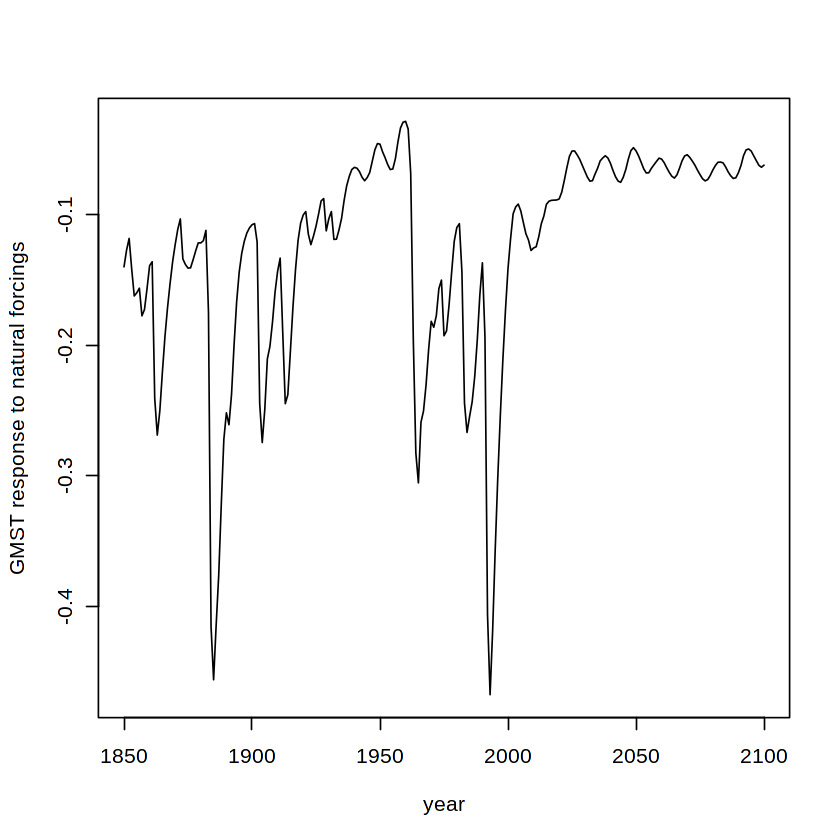

In [4]:
year = 1850:2100
ny = length(year)

# Load forcings from the Priestley Center
load("FF_CMIP6.rda")
# Plot if needed
#plot(year,FF$FF$nat[FF$FF$year %in% year],type="l")

# Load EBM parameters fitted on available CMIP6 models
load("ebm_params.rda")

ebm_params

# Compute the EBM response e, to be used in equation 7 in Qasmi and Ribes (2021)
e = ebm_response(FF,ebm_params,year,Nres)

# Plot the best-estimate of e
plot(year,e[,"be"],type="l", ylab="GMST response to natural forcings")

### Reponse to the anthropogenic and all external forcings for GMST

We estimate the response to anthropogenic and all forcings by fitting a Generalized Additive Model (GAM) on each ensemble mean from the CMIP6 models. An uncertainty on each forced response is considered by using the pre-industrial control (piControl) simulations.

First, we pre-process the input variables:

In [5]:
# Load historical+ssp585 GMST ensemble means from CMIP6 models
X_glo_scen_tmp = loadRData("GMST_CMIP6_histssp585_ann_idx.Rdata")

# Extract the scenario and the chosen simulated years
X_glo_scen_full = X_glo_scen_tmp[as.character(year),"histssp585",,]

# Consider the same models in historical+ssp585 and piControl simulations
models_scen_full = dimnames(X_glo_scen_full)$model
# Check if any NA in times series
models = models_scen_full[apply(is.na(X_glo_scen_full[,,"value"]), 2, sum) == 0] 
# The following CMIP6 models will be used to derive the prior
models

Nmod = length(models)
X_glo_scen = X_glo_scen_full[,models,]

[1] "ACCESS-CM2"      "ACCESS-ESM1-5"   "BCC-CSM2-MR"     "CanESM5-CanOE"  
 [5] "CanESM5"         "CESM2"           "CESM2-WACCM"     "CNRM-CM6-1"     
 [9] "CNRM-CM6-1-HR"   "CNRM-ESM2-1"     "EC-Earth3"       "EC-Earth3-Veg"  
[13] "FGOALS-f3-L"     "FGOALS-g3"       "FIO-ESM-2-0"     "GFDL-ESM4"      
[17] "HadGEM3-GC31-LL" "INM-CM4-8"       "INM-CM5-0"       "IPSL-CM6A-LR"   
[21] "MIROC6"          "MIROC-ES2L"      "MPI-ESM1-2-HR"   "MPI-ESM1-2-LR"  
[25] "MRI-ESM2-0"      "NESM3"           "NorESM2-MM"      "UKESM1-0-LL"

Now, we can fit the GAM on each CMIP6 ensemble mean given the response to natural forcings `e`, and the degrees of freedom `df` for the spline function.

In [6]:
dec_glo = T

if (dec_glo == T) {
    # Extract the forced response to ALL and NAT forcings and fit to a Gaussian distribution
    X_fit_glo = array(NA, dim = c(ny, 2, Nmod),
                  dimnames = list(year = as.character(year),
                                forcing = c("all","nat"),
                                model = models))
    # degrees of freedom for the spline function
    df = 6                            
    message("Decomposition for each model (take some time!)...")
    X_fit_glo[,c("all","nat"),] = x_fit(X_glo_scen[,,"value"], e, df, ant=F)
} else {
    X_fit_glo = loadRData("X_fit_GMST_CMIP6_histssp585_ann.Rdata")
}

Decomposition for each model (take some time!)...

		ACCESS-CM2

		ACCESS-ESM1-5

		BCC-CSM2-MR

		CanESM5-CanOE

		CanESM5

		CESM2

		CESM2-WACCM

		CNRM-CM6-1

		CNRM-CM6-1-HR

		CNRM-ESM2-1

		EC-Earth3

		EC-Earth3-Veg

		FGOALS-f3-L

		FGOALS-g3

		FIO-ESM-2-0

		GFDL-ESM4

		HadGEM3-GC31-LL

		INM-CM4-8

		INM-CM5-0

		IPSL-CM6A-LR

		MIROC6

		MIROC-ES2L

		MPI-ESM1-2-HR

		MPI-ESM1-2-LR

		MRI-ESM2-0

		NESM3

		NorESM2-MM

		UKESM1-0-LL



Plot the decomposition for the ACCESS-CM2 model (change the loop in the third cell to test other models if necessary), and check that the decomposition of GMST is correct.

### Modeling observed internal variability within GMST with a Mixture of two Autoregressive (MAR) processes of order 1

We use observations from the Cowtan and Way dataset: https://www-users.york.ac.uk/~kdc3/papers/coverage2013/series.html to compute $\Sigma_\mathrm{obs} = \Sigma_\mathrm{meas.} + \Sigma_\mathrm{iv}$, the observation error covariance matrix. 

In [7]:
# Load observed GMST from Cowtan & Way over 1850-2019
year_obs = 1850:2019
ref_obs = 1961:1990
ny_obs = length(year_obs)
Xo_glo_full = loadRData("GMST_CW_ann.Rdata")
Xo_glo = Xo_glo_full[as.character(year_obs),]

# Check the ensemble size: 170 years, 100 members
dim(Xo_glo)

[1] 170 100

We first build the covariance matrix for internal variability $\Sigma_\mathrm{iv,glo}$, by fitting the MAR parameters to an estimate of observed internal variability.

In [8]:
# Estimate the response to all external forcings by the multimodel ensemble mean
raw_mmm = apply(X_fit_glo[,"all",], 1, mean, na.rm=T)
# Calculate obs residuals, our estimate of internal variability
raw_mmm_c = raw_mmm - mean(raw_mmm[year %in% ref_obs]) # raw_mmm_c must be anomalies wrt 1961-1990
Xo_glo_med = apply(Xo_glo, 1, median)
Xo_glo_c = Xo_glo_med - mean(Xo_glo_med[year_obs %in% ref_obs])
res_glo = Xo_glo_c - raw_mmm_c[as.character(year_obs)]
# Fit the parameters of the MAR models on residuals
message("Fitting MAR parameters (may take some time!)...")
theta_obs_glo = estim_mar2_link(res_glo)
# Compute the associated covariance matrix
Sigma2_obs_iv_glo = Sigma_mar2(theta_obs_glo,res_glo)


Fitting MAR parameters (may take some time!)...



initial  value -626.185111 
iter   2 value -627.488879
iter   3 value -628.048886
iter   4 value -628.818852
iter   5 value -629.108266
iter   6 value -629.679650
iter   7 value -629.917977
iter   8 value -629.991425
iter   9 value -630.010280
iter  10 value -630.014598
iter  11 value -630.014650
iter  12 value -630.014751
iter  13 value -630.014826
iter  14 value -630.014854
iter  15 value -630.014866
iter  16 value -630.014905
iter  17 value -630.014920
iter  17 value -630.014924
iter  17 value -630.014924
final  value -630.014924 
converged


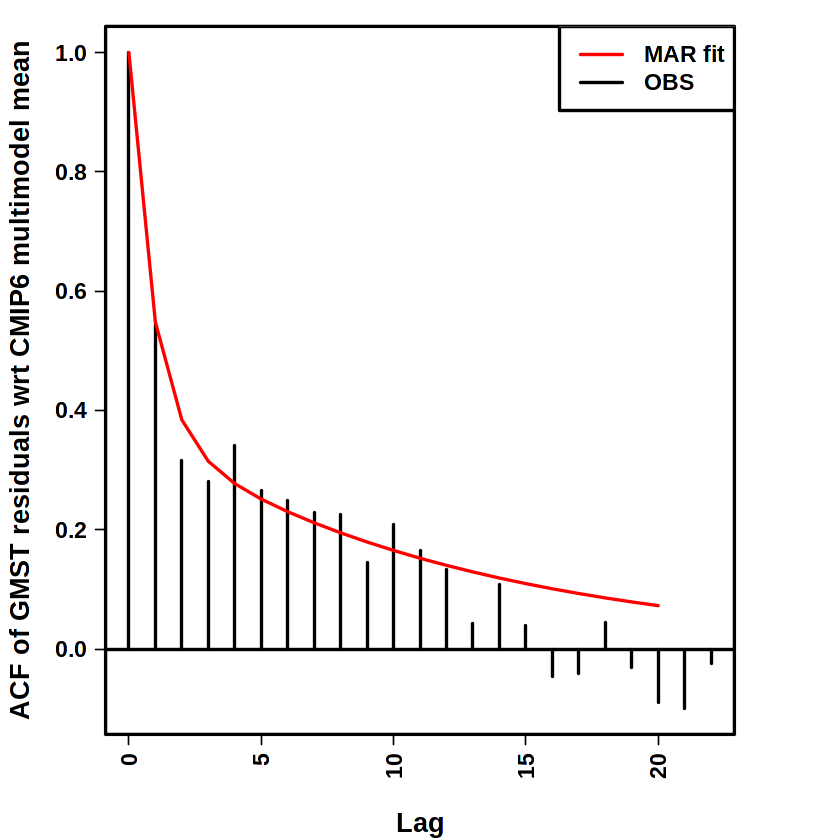

In [9]:
# Check that MAR modelling is ok
acf_res = acf(res_glo, plot=F)
par(cex=1.1,font=2, font.lab=2,font.axis=2,lwd=2,mgp=c(2.8,.7,0),mar=c(4,4,1,4),las=2,tcl=-.4,cex.lab=1.2)
plot(acf_res,ylab="ACF of GMST residuals wrt CMIP6 multimodel mean",ci=0,lwd=2)
colors_acf = c("red", "black")
lines(0:20, Sigma2_obs_iv_glo[1,1:21]/Sigma2_obs_iv_glo[1,1], col=colors_acf[1], lwd=2)
legend("topright", legend = c("MAR fit", "OBS"), col = colors_acf, lwd=2, lty=1)

The covariance matrix for measurement errors is computed over the 100 members.

In [10]:
# Add the covariance matrix for measurement errors
Sigma2_obs_glo = Sigma2_obs_iv_glo + var(t(Xo_glo))

### Constraint of the GMST projections

All the ingredients are now gathered to apply the constraint using the gaussian conditioning theorem.

In [11]:
# Constrain of GMST
message("Retrieve the results from Ribes et al. 2020 by constraining simulated GMST by observations")
X_krig_glo_list = prior2posterior(X_fit_glo, Xo_glo, Sigma2_obs_glo, Nres, centering_CX=T, ref_CX=1850:1900)

# Convert output lists to arrays
# X_unconstrained
X_uncons_glo = mvgauss_to_Xarray(X_krig_glo_list$uncons$mean,X_krig_glo_list$uncons$var,Nres)
# X_constrained
X_cons_glo = mvgauss_to_Xarray(X_krig_glo_list$cons$mean,X_krig_glo_list$cons$var,Nres)

# Bind X_uncons and X_cons together using the abind library
library(abind)
l_tmp = c(dimnames(X_uncons_glo)[1:3], list(constrain=c("uncons","cons")))
X_krig_glo = abind(X_uncons_glo, X_cons_glo, along=4)
dimnames(X_krig_glo) = l_tmp

Retrieve the results from Ribes et al. 2020 by constraining simulated GMST by observations



Check the kriging performance by plotting prior and posterior distributions (see Figure 2c in Ribes et al 2021):

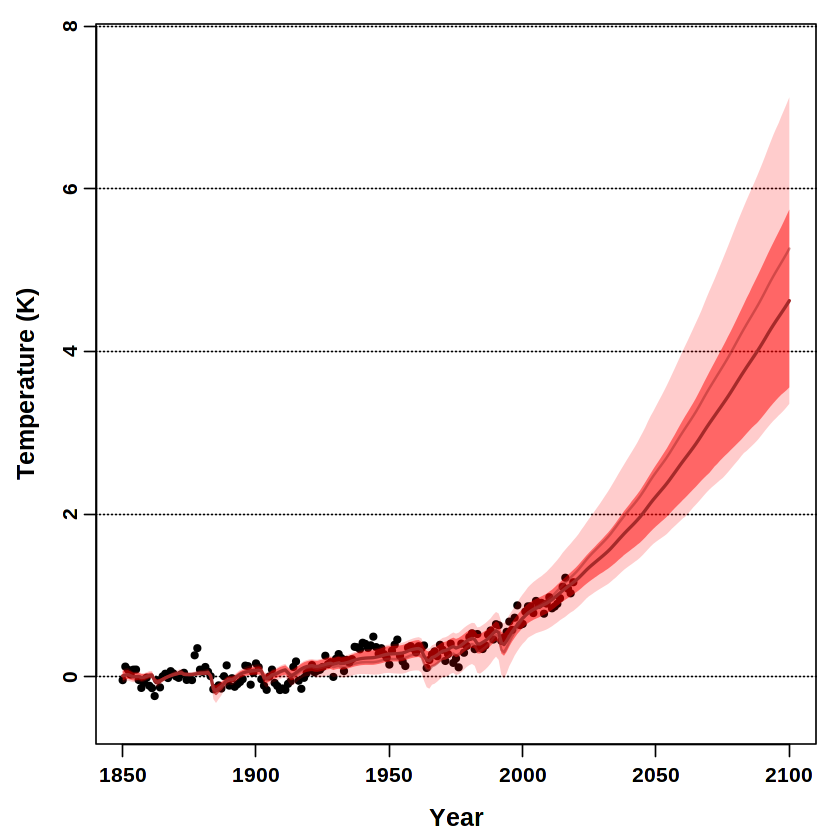

In [12]:
ylim = c(-.5,7.7)
ref_plot = 1850:1900

plot_cons(X_krig_glo, Xo_glo, ref_plot=ref_plot, ny=ny, ylim=ylim)

### Reponse to the anthropogenic and all external forcings of the local temperature over 

As done for the GMST, we fit a GAM on each CMIP6 model ensemble mean and consider local time series over Dallas, by applying the same above procedure. For the sake of simplicity, here we load directly the local response returned by `x_fit`.

In [13]:
message("Load simulated local temperature responses to external forcings")
X_fit_loc = loadRData("X_fit_tblend_CMIP6_histssp585_ann_Dallas.Rdata")

Load simulated local temperature responses to external forcings



### Modeling observed local internal variability with the MAR statistical representation

Similarly to the GMST case, we estimate local internal variability using observed temperatures in Dallas:

In [14]:
message("Load observed local temperatures from Cowtan & Way over 1850-2019")
Xo_loc_full = loadRData("tblend_CW_ann_Dallas.Rdata")
Xo_loc = Xo_loc_full[as.character(year_obs),]

Load observed local temperatures from Cowtan & Way over 1850-2019



Computation of $\Sigma_\mathrm{iv,loc}$:

In [15]:
# Estimate the response to all external forcings by the multimodel ensemble mean
raw_mmm = apply(X_fit_loc[,"be","all",], 1, mean, na.rm=T)
# Calculate obs residuals, our estimate of internal variability 
raw_mmm_c = raw_mmm - mean(raw_mmm[year %in% ref_obs]) # raw_mmm_c must be anomalies wrt 1961-1990
Xo_loc_med = apply(Xo_loc, 1, median)
Xo_loc_c = Xo_loc_med - mean(Xo_loc_med[year_obs %in% ref_obs])
res_loc = Xo_loc_c - raw_mmm_c[as.character(year_obs)]
# Fit the parameters of the MAR models on residuals
message("Fitting MAR parameters (may take some time!)...")
theta_obs_loc = estim_mar2_link(res_loc)
# Compute the associated covariance matrix
Sigma2_obs_iv_loc = Sigma_mar2(theta_obs_loc,res_loc)


Fitting MAR parameters (may take some time!)...



initial  value 16.863653 
iter   2 value -3.973797
iter   3 value -5.777021
iter   4 value -7.263366
iter   5 value -10.247414
iter   6 value -11.984295
iter   7 value -12.808316
iter   8 value -15.281647
iter   9 value -16.035370
iter  10 value -16.624814
iter  11 value -16.654181
iter  12 value -16.668295
iter  13 value -16.730890
iter  14 value -16.783888
iter  15 value -16.836309
iter  16 value -17.005581
iter  17 value -17.223481
iter  18 value -17.420639
iter  19 value -17.483716
iter  20 value -17.483823
iter  21 value -17.483849
iter  22 value -17.484183
iter  23 value -17.484329
iter  24 value -17.484491
iter  25 value -17.485124
iter  26 value -17.486359
iter  27 value -17.488841
iter  28 value -17.491998
iter  29 value -17.493213
iter  30 value -17.493247
iter  31 value -17.493473
iter  32 value -17.493619
iter  33 value -17.493672
iter  34 value -17.493677
iter  35 value -17.493821
iter  36 value -17.493989
iter  37 value -17.494231
iter  38 value -17.494299
iter  39 value 

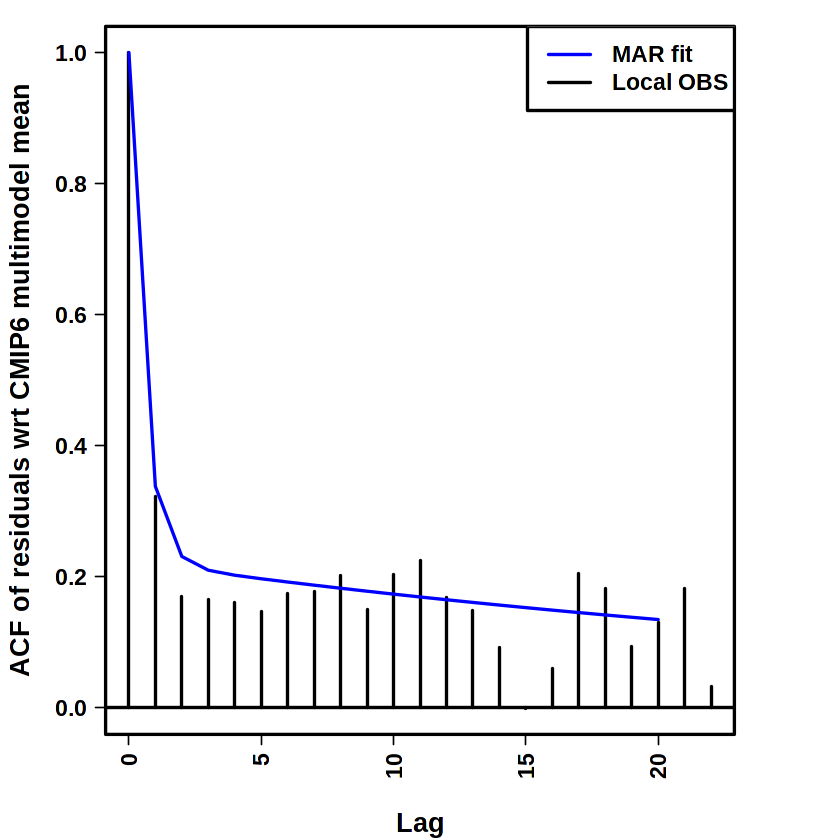

In [16]:
# Check that MAR modelling is ok
acf_res = acf(res_loc, plot=F)
par(cex=1.1,font=2, font.lab=2,font.axis=2,lwd=2,mgp=c(2.8,.7,0),mar=c(4,4,1,4),las=2,tcl=-.4,cex.lab=1.2)
plot(acf_res,ylab="ACF of residuals wrt CMIP6 multimodel mean",ci=0,lwd=2)
colors_acf = c("blue", "black")
lines(0:20, Sigma2_obs_iv_loc[1,1:21]/Sigma2_obs_iv_loc[1,1], col=colors_acf[1], lwd=2)
legend("topright", legend = c("MAR fit", "Local OBS"), col = colors_acf, lwd=2, lty=1)


In [17]:
# Add the covariance matrix for measurement errors
Sigma2_obs_loc = Sigma2_obs_iv_loc + var(t(Xo_loc))

### Constraint of the local temperature projections over Dallas

Once again, we constrain temperature projections, but for Dallas. The two options mentionned in Qasmi and Ribes (2021) are tested.

#### Constraint by local+global observations

First option: using both GMST observations and local observations.

In [18]:
models = intersect(dimnames(X_fit_loc)$model,dimnames(X_fit_glo)$model)

# Bind arrays containing the local and global responses returned by x_fit
X_fit = abind(X_fit_loc[,"be",,models], X_fit_glo[,,models], along=1, use.dnns=T)
# Rearrange dimensions along year dimension
year_loc = paste0(as.character(year),"loc")
year_glo = paste0(as.character(year),"glo")
dimnames(X_fit)$year = c(year_loc, year_glo)

# Bind arrays containing the local and global observations
Xo = abind(Xo_loc, Xo_glo, along=1, use.dnns=T)
year_obs_loc = paste0(as.character(year_obs),"loc")
year_obs_glo = paste0(as.character(year_obs),"glo")
dimnames(Xo)$year = c(year_obs_loc, year_obs_glo)

Since we are dealing with both local and global observations, we need to account for the dependance between local and global residuals, and compute $\Sigma_\mathrm{iv,dep}$, the anti-diagonal block in $\Sigma_\mathrm{iv}$ see equation 10 in Supplementary Material of Qasmi and Ribes (2021).

In [19]:
message("Accounting for dependence parameters in the covariance matrix")
res_loc_glo = list(res_loc, res_glo)
theta_obs_loc_glo = estim_mar_dep(theta_obs_loc,theta_obs_glo,res_loc_glo) # by the method of moments
#theta_obs_loc_glo = estim_mar_dep_full(res_loc_glo) # by maximum likelihood (takes some time)

# Compute the associated covariance matrix
Sigma2_obs_iv_loc_glo = Sigma_mar_dep(theta_obs_loc_glo,res_loc_glo)

# Check that the dimensions are correct
dim(Sigma2_obs_iv_loc_glo)

Accounting for dependence parameters in the covariance matrix



[1] 340 340

In [20]:
# Add the covariance matrix for measurement errors
Sigma2_obs_loc_glo = Sigma2_obs_iv_loc_glo + var(t(Xo))

In [21]:
# Constrain by local+global observations
X_krig_loc_glo_list = prior2posterior(X_fit, Xo, Sigma2_obs_loc_glo, Nres, centering_CX=T, ref_CX=c(paste0(1850:1900,"loc"),paste0(1850:1900,"glo")))

# Convert output lists to arrays
# X_unconstrained
X_uncons_loc_glo = mvgauss_to_Xarray(X_krig_loc_glo_list$uncons$mean,X_krig_loc_glo_list$uncons$var,Nres)
# X_constrained
X_cons_loc_glo = mvgauss_to_Xarray(X_krig_loc_glo_list$cons$mean,X_krig_loc_glo_list$cons$var,Nres)

# Bind X_uncons and X_cons together using the abind library
l_tmp = c(dimnames(X_uncons_loc_glo)[1:3], list(constrain=c("uncons","cons")))
X_krig_loc_glo = abind(X_uncons_loc_glo, X_cons_loc_glo, along=4)
dimnames(X_krig_loc_glo) = l_tmp

Check the kriging performance by plotting prior and posterior distributions (see Figure 2b in Qasmi and Ribes 2021):

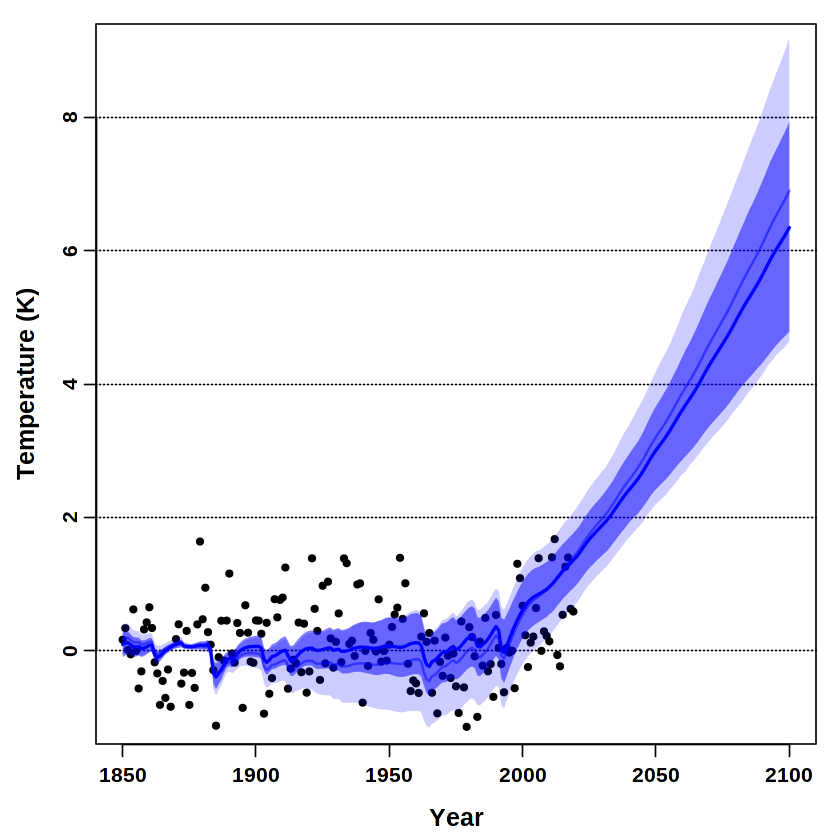

In [22]:
ylim = c(-1.,9.)
ref_plot = 1850:1900

dimnames(X_krig_loc_glo)$year = c(year,year_glo)
plot_cons(X_krig_loc_glo, Xo_loc, ref_plot=ref_plot, ny=ny, ylim=ylim,color="blue")

#### Constraint by GMST observations only

Second option: using GMST observations only. We keep the structure of the binded array of the local and global temperature responses, and only use GMST observations as input in the `prior2posterior` function.

In [23]:
# Rename year dimension of GMST
dimnames(Xo_glo)$year = year_obs_glo

# Constraint by GMST observations only
X_krig_glo_only_list = prior2posterior(X_fit, Xo_glo, Sigma2_obs_glo, Nres, centering_CX=T, ref_CX=paste0(1850:1900,"glo"))

# Convert output lists to arrays
# X_unconstrained
X_uncons_glo_only = mvgauss_to_Xarray(X_krig_glo_only_list$uncons$mean,X_krig_glo_only_list$uncons$var,Nres)
# X_constrained
X_cons_glo_only = mvgauss_to_Xarray(X_krig_glo_only_list$cons$mean,X_krig_glo_only_list$cons$var,Nres)

# Bind X_uncons and X_cons together using the abind library
l_tmp = c(dimnames(X_uncons_glo_only)[1:3], list(constrain=c("uncons","cons")))
X_krig_glo_only = abind(X_uncons_glo_only, X_cons_glo_only, along=4)
dimnames(X_krig_glo_only) = l_tmp

Check the kriging performance by plotting prior and posterior distributions (see Figure 2a in Qasmi and Ribes 2021):

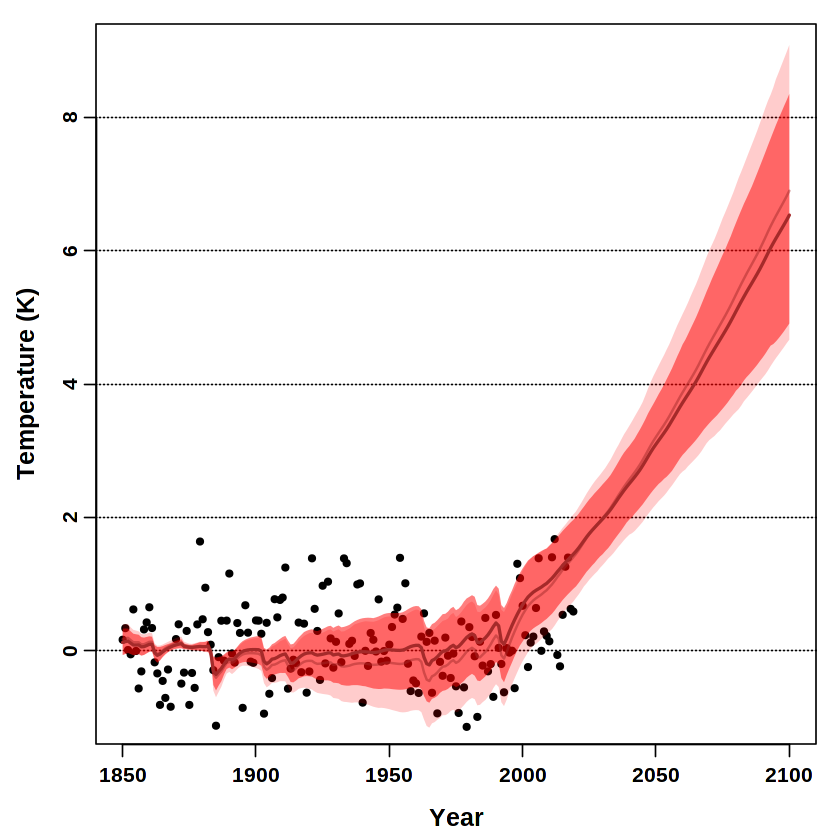

In [24]:
# Rename year dimension
dimnames(Xo_glo)$year = year_obs
dimnames(X_krig_glo_only)$year = c(year,year_glo)

# Plot
ylim = c(-1.,9.)
ref_plot = 1850:1900
Xo_loc_plot = Xo_loc+NA # we do not want local observations on the plot since they are not used in the constraint
plot_cons(X_krig_glo_only, Xo_loc, ref_plot=ref_plot, ny=ny, ylim=ylim)

We can verify that model uncertainty is larger than in the Local+GMST case of about 0.5 degrees in 2100:

In [25]:
write_ci = function(v) {
    message("   ",round(v["be"],2),", [",round(quantile(v[-1],.05),2),", ",round(quantile(v[-1],.95),2),"]")
}

delta_2100_loc_glo = X_krig_loc_glo["2100",,"all","cons"] - apply(X_krig_loc_glo[year %in% 1850:1900,,"all","cons"],2,mean)
delta_2100_glo_only = X_krig_glo_only["2100",,"all","cons"] - apply(X_krig_glo_only[year %in% 1850:1900,,"all","cons"],2,mean)

message("Best-estimate and confidence interval in the Local+GMST case")
write_ci(delta_2100_loc_glo)
message("Best-estimate and confidence interval in the GMST-only case")
write_ci(delta_2100_glo_only)


Best-estimate and confidence interval in the Local+GMST case

   6.52, [4.93, 8.21]

Best-estimate and confidence interval in the GMST-only case

   6.69, [5, 8.65]



#### Additional option: constraint by local observations only

A third and last option mentionned in the Supplementary Information of Qasmi and Ribes (2021) is to use local observations only to perform the kriging interpolation.

In [26]:
dimnames(Xo_loc)$year = year_obs_loc


In [27]:
# Constrain by local observations only
X_krig_loc_list = prior2posterior(X_fit, Xo_loc, Sigma2_obs_loc_glo[year_obs_loc,year_obs_loc], Nres, centering_CX=T, ref_CX=paste0(1850:1900,"loc"))

# Convert output lists to arrays
# X_unconstrained
X_uncons_loc = mvgauss_to_Xarray(X_krig_loc_list$uncons$mean,X_krig_loc_list$uncons$var,Nres)
# X_constrained
X_cons_loc = mvgauss_to_Xarray(X_krig_loc_list$cons$mean,X_krig_loc_list$cons$var,Nres)

# Bind X_uncons and X_cons together using the abind library
l_tmp = c(dimnames(X_uncons_loc)[1:3], list(constrain=c("uncons","cons")))
X_krig_loc = abind(X_uncons_loc, X_cons_loc, along=4)
dimnames(X_krig_loc) = l_tmp

Check the kriging performance by plotting prior and posterior distributions:

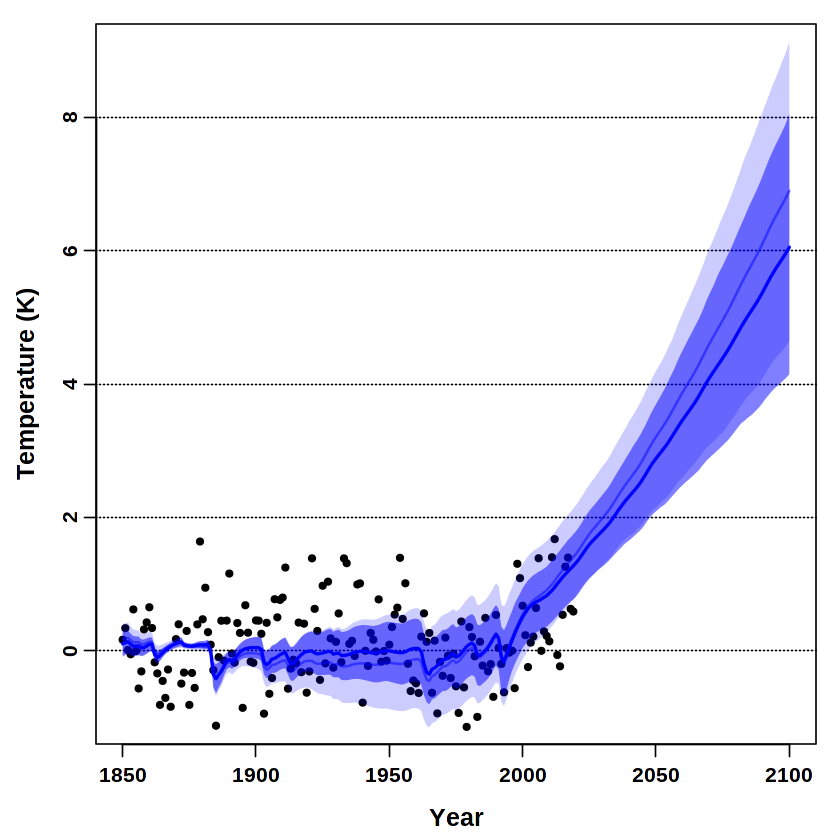

In [28]:
ylim = c(-1.,9.)
ref_plot = 1850:1900
plot_cons(X_krig_loc, Xo_loc, ref_plot=ref_plot, ny=ny, ylim=ylim, color="blue")